In [1]:
import polars as pl
DATA_DIR = "data"

# load all 2024 months of taxi rides
dfs = []
for month in range(1, 13):
    df = pl.scan_parquet(f"{DATA_DIR}/{month}.parquet")
    df = df.with_columns(
        pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
        pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms"),
    )
    dfs.append(df)
df_2024 = pl.concat(dfs)

# also load taxi zone lookup data
taxi_zones = pl.scan_csv(f"{DATA_DIR}/taxi_zone_lookup.csv")

In [2]:
def auto_downcast_numerical(df: pl.LazyFrame) -> pl.LazyFrame:
    numeric_cols = [
        c for c, dt in df.collect_schema().items()
        if dt in (pl.Int64, pl.Int32, pl.Int16, pl.Float64, pl.Float32)
    ]

    if not numeric_cols:
        return df

    stats = (
        df.select(
            [pl.col(c).min().alias(f"{c}_min") for c in numeric_cols]
            + [pl.col(c).max().alias(f"{c}_max") for c in numeric_cols]
        )
        .collect()
        .to_dicts()[0]
    )

    def best_int_dtype(min_val, max_val):
        if -128 <= min_val and max_val <= 127:
            return pl.Int8
        elif -32768 <= min_val and max_val <= 32767:
            return pl.Int16
        elif -2147483648 <= min_val and max_val <= 2147483647:
            return pl.Int32
        else:
            return pl.Int64

    def best_float_dtype(min_val, max_val):
        if abs(min_val) < 3.4e38 and abs(max_val) < 3.4e38:
            return pl.Float32
        return pl.Float64

    for col in numeric_cols:
        dtype = df.collect_schema()[col]
        min_val = stats.get(f"{col}_min")
        max_val = stats.get(f"{col}_max")

        if min_val is None or max_val is None:
            continue

        if dtype.is_integer():
            target_dtype = best_int_dtype(min_val, max_val)
        elif dtype.is_float():
            target_dtype = best_float_dtype(min_val, max_val)
        else:
            continue

        if target_dtype != dtype:
            print(f"Downcasting {col} to {target_dtype}")
            df = df.with_columns(pl.col(col).cast(target_dtype))

    return df


In [3]:
money_cols = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount", 
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
]

df_2024 = (
    ### include only rides starting in 2024 and ending at most at 01.01.2025
    df_2024.filter(
        (pl.col("tpep_pickup_datetime").dt.year() == 2024) & (pl.col("tpep_dropoff_datetime").dt.date() <= pl.date(2025, 1, 1))
    )
    ### optimize data types, particularly for integers and categorical strings
    .pipe(auto_downcast_numerical)
    .with_columns(
        pl.col("store_and_fwd_flag").cast(pl.Categorical),
        trip_time=(pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_minutes(),
    )
        
    ### 2. Data cleaning and filtering
    ### fill NULL values in passengers_count with 1
    .with_columns(pl.col("passenger_count").fill_null(1))
    # remove rides with zero passengers
    .remove(pl.col("passenger_count") == 0)
    ### if a ride has over 6 passengers, replace the value with 6
    .with_columns(
        passenger_count=pl.when(pl.col("passenger_count") > 6).then(pl.lit(6)).otherwise(pl.col("passenger_count"))
    )
    ### remove rides lasting over 2 hours
    .remove(pl.col("trip_time") > 120)
    ### in all money-related columns, replace values with absolute value to fix negative amounts
    .with_columns(
        [pl.col(money_col).abs() for money_col in money_cols]
    )
    ### remove rides with over 1000 dollars in any money-related column
    .remove(pl.any_horizontal([pl.col(money_col) > 1000 for money_col in money_cols]))
    ### remove rows with values of RatecodeID or VendorID missing or outside those defined in the data dictionary
    .remove(pl.col("VendorID").is_null() | ~pl.col("VendorID").is_in([1, 2, 6, 7]))
    .remove(pl.col("RatecodeID").is_null() | ~pl.col("RatecodeID").is_in([1, 2, 3, 4, 5, 6, 99]))

    
    ### 3. Data transformation
    ### combine payment type values for "No charge", "Dispute", "Unknown" and "Voided trip" into one type, so we have only credit card, cash, or other
    .with_columns(
        pl.col("payment_type").replace_strict(
            {
                1: "card",
                2: "cash",
                3: "other",
                4: "other",
                5: "other",
                6: "other"
            }
        )
        .cast(pl.Categorical)
    )
    ### replace PULocationID and DOLocationID with borough names by joining taxi zone lookup and removing unnecessary columns
    .join(
        taxi_zones,
        how="left",
        left_on=pl.col("PULocationID"),
        right_on=pl.col("LocationID"),
        suffix="PU"
    )
    .join(
        taxi_zones,
        how="left",
        left_on=pl.col("DOLocationID"),
        right_on=pl.col("LocationID"),
        suffix="DO"
    )
    .rename({
        "Borough" : "pickup_borough",
        "BoroughDO" : "dropoff_borough"
    })
    .drop([
        "Zone",
        "service_zone",
        "ZoneDO",
        "service_zoneDO",
        "PULocationID",
        "DOLocationID"
    ])
    ### add boolean variable is_airport_ride, true if there is non-zero airport fee
    .with_columns(
        is_airport_ride = pl.col("Airport_fee") > 0
    )
    ### add boolean variable is_rush_hour, rush hours are defined as 6:30–9:30 and 15:30-20:00 during weekdays
    .with_columns(
        is_rush_hour=(pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(6, 30), pl.time(9, 30)))
        | (pl.col("tpep_pickup_datetime").dt.time().is_between(pl.time(15, 30), pl.time(20, 0)))
    )
)

Downcasting VendorID to Int8
Downcasting passenger_count to Int8
Downcasting trip_distance to Float32
Downcasting RatecodeID to Int8
Downcasting PULocationID to Int16
Downcasting DOLocationID to Int16
Downcasting payment_type to Int8
Downcasting fare_amount to Float32
Downcasting extra to Float32
Downcasting mta_tax to Float32
Downcasting tip_amount to Float32
Downcasting tolls_amount to Float32
Downcasting improvement_surcharge to Float32
Downcasting total_amount to Float32
Downcasting congestion_surcharge to Float32
Downcasting Airport_fee to Float32


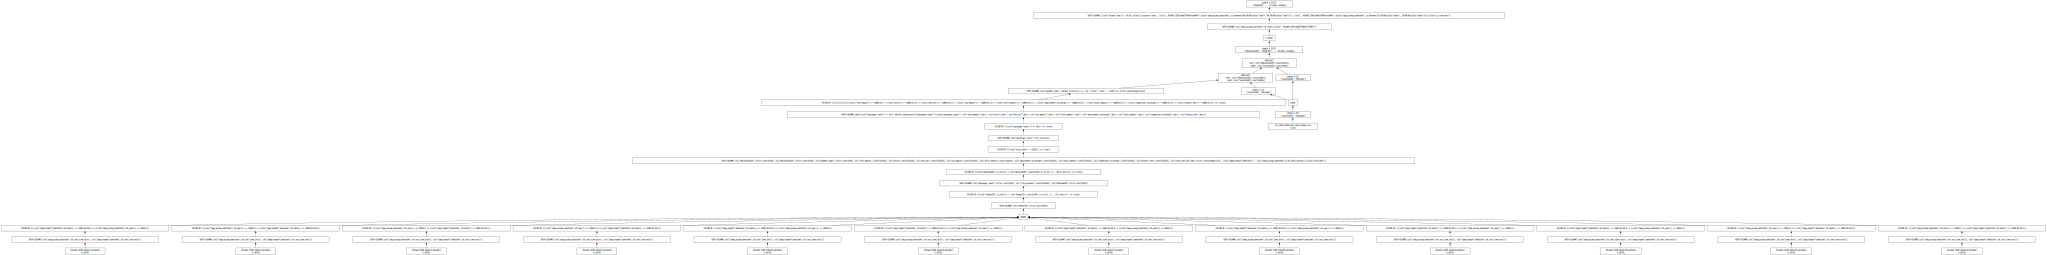

In [4]:
df_2024.show_graph()

In [7]:
df_2024 = df_2024.collect()

AttributeError: 'DataFrame' object has no attribute 'collect'

In [8]:
df_2024

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_time,pickup_borough,dropoff_borough,is_airport_ride,is_rush_hour
i8,datetime[ms],datetime[ms],i8,f32,i8,cat,cat,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,str,str,bool,bool
2,2024-01-01 00:57:55,2024-01-01 01:17:43,1,1.72,1,"""N""","""cash""",17.700001,1.0,0.5,0.0,0.0,1.0,22.700001,2.5,0.0,19,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1,1.8,1,"""N""","""card""",10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,6,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:17:06,2024-01-01 00:35:01,1,4.7,1,"""N""","""card""",23.299999,3.5,0.5,3.0,0.0,1.0,31.299999,2.5,0.0,17,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:36:38,2024-01-01 00:44:56,1,1.4,1,"""N""","""card""",10.0,3.5,0.5,2.0,0.0,1.0,17.0,2.5,0.0,8,"""Manhattan""","""Manhattan""",false,false
1,2024-01-01 00:46:51,2024-01-01 00:52:57,1,0.8,1,"""N""","""card""",7.9,3.5,0.5,3.2,0.0,1.0,16.1,2.5,0.0,6,"""Manhattan""","""Manhattan""",false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2,2024-12-31 22:56:33,2024-12-31 23:05:57,1,1.9,1,"""N""","""card""",12.1,1.0,0.5,1.88,0.0,1.0,18.98,2.5,0.0,9,"""Manhattan""","""Manhattan""",false,false
2,2024-12-31 23:18:37,2024-12-31 23:32:32,1,3.88,1,"""N""","""cash""",19.1,1.0,0.5,0.0,0.0,1.0,24.1,2.5,0.0,13,"""Manhattan""","""Queens""",false,false
2,2024-12-31 23:08:52,2024-12-31 23:34:59,1,5.53,1,"""N""","""card""",29.6,1.0,0.5,2.0,0.0,1.0,36.599998,2.5,0.0,26,"""Manhattan""","""Brooklyn""",false,false


In [ ]:
(
    ### 4. Feature extraction
    ### apply dummy encoding to features:
    ###     payment type
    ###     pickup borough
    ###     dropoff borough
    df_2024.to_dummies(["payment_type", "pickup_borough", "dropoff_borough"])
    .lazy()
)